# Preprocessing
----------------------

This part of the kernel focuses on preprocessing the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import random
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats

# import the relevant Keras modules
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, LSTM, Dropout, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


## Cleaning and processing data

In [2]:
DATA_PATH = '/run/media/sphericalkat/archive/datasets/city_temperature/city_temperature.csv'
data = pd.read_csv(DATA_PATH, 
                   dtype={'States': 'string'}, 
                   low_memory=False,
                  )

# Drop columns we won't be using
data.drop(['Region', 'Country', 'State'], inplace=True, axis=1)

# Let's train on one city
input_data = data.loc[data['City'] == 'Chicago']
input_data['Date'] = pd.to_datetime(input_data[['Year', 'Month', 'Day']])
input_data.drop(['Month', 'Day', 'Year'], inplace=True, axis=1)

# Drop outliers
input_data = input_data.loc[(np.abs(stats.zscore(input_data['AvgTemperature'])) < 3)]

input_data.head()

,City,AvgTemperature,Date
1831781,Chicago,23.7,1995-01-01
1831782,Chicago,13.8,1995-01-02
1831783,Chicago,14.1,1995-01-03
1831784,Chicago,3.8,1995-01-04
1831785,Chicago,5.0,1995-01-05


## Visualization

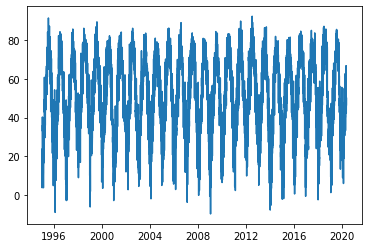

In [3]:
plt.plot(input_data['Date'], input_data['AvgTemperature'])
plt.show()

## Converting series to supervised

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [5]:
reframed = series_to_supervised(input_data, 1, 1)
reframed.drop(reframed.columns[[0, 2, 3, 5]], inplace=True, axis=1)
reframed.head()

,var2(t-1),var2(t)
1831782,23.7,13.8
1831783,13.8,14.1
1831784,14.1,3.8
1831785,3.8,5.0
1831786,5.0,21.4


## Prepare data for training

In [6]:
# Train-test split
values = reframed.values
train, test = train_test_split(values)

# Split into input and output
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
y_train = scaler2.fit_transform(y_train.reshape(-1, 1))

X_test = scaler1.transform(X_test)
y_test = scaler2.transform(y_test.reshape(-1, 1))


# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6933, 1, 1) (6933, 1) (2311, 1, 1) (2311, 1)


## Define and compile model

In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath="weights.h5", 
        monitor="val_loss", 
        mode='min', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(X_train.shape[2]))

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), 
          verbose=2, shuffle=False, callbacks=callbacks)

model.load_weights('weights.h5')
model.save('model.pb')

Train on 6933 samples, validate on 2311 samples
Epoch 1/50
 - 3s - loss: 0.3470 - val_loss: 0.1036

Epoch 00001: val_loss improved from inf to 0.10359, saving model to weights.h5
Epoch 2/50
 - 1s - loss: 0.1030 - val_loss: 0.0825

Epoch 00002: val_loss improved from 0.10359 to 0.08255, saving model to weights.h5
Epoch 3/50
 - 1s - loss: 0.0843 - val_loss: 0.0588

Epoch 00003: val_loss improved from 0.08255 to 0.05881, saving model to weights.h5
Epoch 4/50
 - 1s - loss: 0.0689 - val_loss: 0.0516

Epoch 00004: val_loss improved from 0.05881 to 0.05162, saving model to weights.h5
Epoch 5/50
 - 1s - loss: 0.0639 - val_loss: 0.0479

Epoch 00005: val_loss improved from 0.05162 to 0.04793, saving model to weights.h5
Epoch 6/50
 - 1s - loss: 0.0635 - val_loss: 0.0477

Epoch 00006: val_loss improved from 0.04793 to 0.04766, saving model to weights.h5
Epoch 7/50
 - 1s - loss: 0.0624 - val_loss: 0.0479

Epoch 00007: val_loss did not improve from 0.04766
Epoch 8/50
 - 1s - loss: 0.0617 - val_loss:

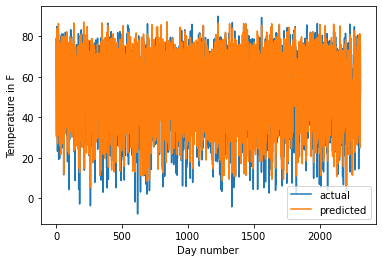

In [9]:
model = load_model("model.pb")
plt.plot(scaler2.inverse_transform(y_test.reshape(-1, 1)), label = "actual")
plt.plot(scaler1.inverse_transform(model.predict(X_test)), label = "predicted")
plt.xlabel('Day number')
plt.ylabel('Temperature in F')
plt.legend()
plt.show()